## Módulos

In [26]:
!pip install -q yfinance

In [27]:
#Cotações do Yahoo Finance
import yfinance as yf

# Tratamento de Dados
import pandas as pd
from pandas.tseries.offsets import BDay
pd.set_option("display.max_colwidth", 150)

#Gráficos
import plotly.graph_objects as go
import plotly.express as px
import seaborn as sns

#Utilidades
from datetime import date

## Funções

In [28]:
def busca_cadastro_cvm(data=(date.today()-BDay(2))):
  if data is not busca_cadastro_cvm.__defaults__[0]:
    data = pd.to_datetime(data)

  try:
    url = 'http://dados.cvm.gov.br/dados/FI/CAD/DADOS/cad_fi.csv'.format(data.year, data.month, data.day)
    return pd.read_csv(url, sep=';', encoding='ISO-8859-1')

  except:
    print("Arquivo {} não encontrado!".format(url))
    print("Forneça outra data!")

In [29]:
def busca_informes_diarios_cvm_por_periodo(data_inicio, data_fim):
  datas = pd.date_range(data_inicio, data_fim, freq='MS')
  informe_completo = pd.DataFrame()

  for data in datas:
    try:
      url ='http://dados.cvm.gov.br/dados/FI/DOC/INF_DIARIO/DADOS/inf_diario_fi_{}{:02d}.zip'.format(data.year, data.month)
      informe_mensal = pd.read_csv(url, sep=';')

    except:
      print("Arquivo {} não encontrado!".format(url))

    informe_completo = pd.concat([informe_completo, informe_mensal], ignore_index=True)

  return informe_completo

In [30]:
def melhores_e_piores(informes, cadastro, top=7, minimo_de_cotistas=100, classe=''):
  cadastro      = cadastro[cadastro['SIT'] == 'EM FUNCIONAMENTO NORMAL']
  fundos        = informes[informes['NR_COTST'] >= minimo_de_cotistas]


  cnpj_informes = fundos['CNPJ_FUNDO'].drop_duplicates()

  fundos = fundos.pivot_table(index='DT_COMPTC', columns='CNPJ_FUNDO')
  cotas_normalizadas = fundos['VL_QUOTA'] / fundos['VL_QUOTA'].iloc[0]

  if classe == 'multimercado':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Multimercado']['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'acoes':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Ações']['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'rendafixa':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo de Renda Fixa']['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  if classe == 'cambial':
    cnpj_cadastro      = cadastro[cadastro['CLASSE'] == 'Fundo Cambial']['CNPJ_FUNDO']
    cotas_normalizadas = cotas_normalizadas[cnpj_cadastro[cnpj_cadastro.isin(cnpj_informes)]]

  #melhores
  melhores = pd.DataFrame()
  melhores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=False)[:top] - 1) * 100
  for cnpj in melhores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    melhores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    melhores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    melhores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]

  #piores
  piores = pd.DataFrame()
  piores['retorno(%)'] = (cotas_normalizadas.iloc[-1].sort_values(ascending=True)[:top] - 1) * 100
  for cnpj in piores.index:
    fundo = cadastro[cadastro['CNPJ_FUNDO'] == cnpj]
    piores.at[cnpj, 'Fundo de Investimento'] = fundo['DENOM_SOCIAL'].values[0]
    piores.at[cnpj, 'Classe']                = fundo['CLASSE'].values[0]
    piores.at[cnpj, 'PL']                    = fundo['VL_PATRIM_LIQ'].values[0]

  return melhores, piores

In [31]:
def consulta_fundo(informes, cnpj):
  fundo = informes[informes['CNPJ_FUNDO'] == cnpj].copy()
  fundo.set_index('DT_COMPTC', inplace=True)
  fundo['cotas_normalizadas'] = (fundo['VL_QUOTA'] / fundo['VL_QUOTA'].iloc[0])*100
  return fundo

In [32]:
def cdi_acumulado(data_inicio, data_fim):
  codigo_bcb = 12

  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  cdi = pd.read_json(url)
  cdi['data'] = pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True)

  cdi_acumulado = (1 + cdi[data_inicio : data_fim] / 100).cumprod()
  cdi_acumulado.iloc[0] = 1
  return cdi_acumulado

## Benckmarks

In [33]:
cdi = cdi_acumulado('2023-01-01', '2023-12-31') * 100
cdi

,valor
data,
2023-01-02,100.000000
2023-01-03,100.101602
2023-01-04,100.152441
2023-01-05,100.203307
2023-01-06,100.254198
...,...
2023-12-22,112.841881
2023-12-26,112.891237
2023-12-27,112.940615


In [34]:
ibov = yf.download('^BVSP', start='2023-01-01', end='2023-12-31')['Close']
ibov = (ibov / ibov.iloc[0])*100

[*********************100%%**********************]  1 of 1 completed


In [35]:
ibov

Date
2023-01-02    100.000000
2023-01-03     97.922464
2023-01-04     99.020456
2023-01-05    101.073550
2023-01-06    102.312552
                 ...    
2023-12-21    124.259231
2023-12-22    124.796007
2023-12-26    125.529255
2023-12-27    126.150635
2023-12-28    126.142175
Name: Close, Length: 248, dtype: float64

In [36]:
ibov.info

<bound method Series.info of Date
2023-01-02    100.000000
2023-01-03     97.922464
2023-01-04     99.020456
2023-01-05    101.073550
2023-01-06    102.312552
                 ...    
2023-12-21    124.259231
2023-12-22    124.796007
2023-12-26    125.529255
2023-12-27    126.150635
2023-12-28    126.142175
Name: Close, Length: 248, dtype: float64>

SELIC

In [37]:
def selic_acumulada(data_inicio, data_fim):
  codigo_bcb = 11

  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(codigo_bcb)
  selic = pd.read_json(url)
  selic['data'] = pd.to_datetime(selic['data'], dayfirst=True)
  selic.set_index('data', inplace=True)

  selic_acumulada = (1 + selic[data_inicio : data_fim] / 100).cumprod()
  selic_acumulada.iloc[0] = 1
  return selic_acumulada


In [38]:
selic= selic_acumulada('2023-01-01', '2023-12-31') * 100
selic

,valor
data,
2023-01-02,100.000000
2023-01-03,100.101602
2023-01-04,100.152441
2023-01-05,100.203307
2023-01-06,100.254198
...,...
2023-12-22,112.841881
2023-12-26,112.891237
2023-12-27,112.940615


In [39]:
selic.info

<bound method DataFrame.info of                  valor
data                  
2023-01-02  100.000000
2023-01-03  100.101602
2023-01-04  100.152441
2023-01-05  100.203307
2023-01-06  100.254198
...                ...
2023-12-22  112.841881
2023-12-26  112.891237
2023-12-27  112.940615
2023-12-28  112.990014
2023-12-29  113.039435

[249 rows x 1 columns]>

In [40]:
selic=selic.squeeze()

In [41]:
selic

data
2023-01-02    100.000000
2023-01-03    100.101602
2023-01-04    100.152441
2023-01-05    100.203307
2023-01-06    100.254198
                 ...    
2023-12-22    112.841881
2023-12-26    112.891237
2023-12-27    112.940615
2023-12-28    112.990014
2023-12-29    113.039435
Name: valor, Length: 249, dtype: float64

## Buscando Dados da CVM

In [42]:
cadastro = busca_cadastro_cvm()
cadastro

<ipython-input-28-ed827a3a231c>:7: DtypeWarning:

Columns (14,17,18,20,22,24,27,37,38,39,40) have mixed types. Specify dtype option on import or set low_memory=False.



,TP_FUNDO,CNPJ_FUNDO,DENOM_SOCIAL,DT_REG,DT_CONST,CD_CVM,DT_CANCEL,SIT,DT_INI_SIT,DT_INI_ATIV,...,CPF_CNPJ_GESTOR,GESTOR,CNPJ_AUDITOR,AUDITOR,CNPJ_CUSTODIANTE,CUSTODIANTE,CNPJ_CONTROLADOR,CONTROLADOR,INVEST_CEMPR_EXTER,CLASSE_ANBIMA
0,FACFIF,00.000.684/0001-21,DEUTSCHE BANK FDO APLIC QUOTAS FDO INV FINANCEIRO - MAX,2003-04-30,1994-12-20,19.0,2000-08-01,CANCELADA,2000-08-01,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,FACFIF,00.000.731/0001-37,ITAMARITI CASH FUNDO APLICACAO QUOTAS FDOS INVESTIMENTO,2003-04-30,1994-05-18,40681.0,1996-01-26,CANCELADA,1996-01-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FACFIF,00.000.732/0001-81,FUNDO APLIC. QUOTAS DE F.I. SANTANDER CURTO PRAZO,2003-04-30,1994-05-24,27.0,1999-09-03,CANCELADA,1999-09-03,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,FACFIF,00.000.740/0001-28,FUNDO DE APLIC EM QUOTAS DE FUNDOS DE INV BMC 60 DIAS URV,2003-04-30,1994-05-23,40690.0,1996-06-10,CANCELADA,1996-06-10,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,FACFIF,00.000.749/0001-39,BALANCE FUNDO APLICACAO QUOTAS FUNDO INVESTIMENTO FINANCEIRO,2003-04-30,1994-05-12,35.0,2000-06-26,CANCELADA,2000-06-26,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76272,FUNCINE,31.674.280/0001-47,MEDIA VENTURE ESG INCENTIVADO - FUNDO DE FINANCIAMENTO DA INDUSTRIA CINEMATOGRAFICA NACIONAL,2018-10-26,2018-09-13,418001.0,2023-07-21,CANCELADA,2023-07-21,NaN,...,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,16.549.480/0001-84,RSM BRASIL AUDITORES INDEPENDENTES LTDA.,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN,NaN,NaN
76273,FUNCINE,32.222.962/0001-81,Fundo de Financiamento da Indústria Cinematográfica Nacional de Minas Gerais,2018-12-20,2018-11-14,418002.0,2021-10-29,CANCELADA,2021-10-29,NaN,...,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,57.755.217/0001-29,KPMG AUDITORES INDEPENDENTES LTDA.,15.489.568/0001-95,INTRA INVESTIMENTOS DTVM LTDA,NaN,NaN,NaN,NaN
76274,FUNCINE,48.879.897/0001-00,FUNDO DE FINANCIAMENTO DA INDÚSTRIA CINEMATOGRÁFICA NACIONAL - FUNCINE CEDRO LIGOCKI,2022-12-13,2022-12-01,422001.0,NaN,FASE PRÉ-OPERACIONAL,2022-12-13,2022-12-13,...,18.190.296/0001-16,CEDRO ASSET MANAGEMENT LTDA,19.280.834/0001-26,NEXT AUDITORES INDEPENDENTES S/S LTDA.,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN,NaN,NaN
76275,FUNCINE,52.714.528/0001-26,INVESTIMAGE 4 - FUNDO DE FINANCIAMENTO DA INDÚSTRIA CINEMATOGRÁFICA,2023-10-30,2023-10-17,423001.0,NaN,EM FUNCIONAMENTO NORMAL,2023-12-28,2023-12-28,...,09.544.103/0001-97,INVESTIMAGE ADMINISTRADORA DE RECURSOS LTDA.,19.280.834/0001-26,NEXT AUDITORES INDEPENDENTES S/S LTDA.,16.695.922/0001-09,ID CORRETORA DE TITULOS E VALORES MOBILIARIOS S.A.,NaN,NaN,NaN,NaN


In [43]:
informes = busca_informes_diarios_cvm_por_periodo(data_inicio='2023-01', data_fim='2023-12')
informes

,TP_FUNDO,CNPJ_FUNDO,DT_COMPTC,VL_TOTAL,VL_QUOTA,VL_PATRIM_LIQ,CAPTC_DIA,RESG_DIA,NR_COTST
0,FI,00.017.024/0001-53,2023-01-02,1101835.91,30.974427,1104834.84,0.0,0.00,1
1,FI,00.017.024/0001-53,2023-01-03,1102410.18,30.988913,1105351.56,0.0,0.00,1
2,FI,00.017.024/0001-53,2023-01-04,1102994.24,31.003303,1105864.82,0.0,0.00,1
3,FI,00.017.024/0001-53,2023-01-05,1103561.75,31.017294,1106363.87,0.0,0.00,1
4,FI,00.017.024/0001-53,2023-01-06,1103794.86,31.030820,1106846.36,0.0,0.00,1
...,...,...,...,...,...,...,...,...,...
6250626,FI,97.929.213/0001-34,2023-12-22,87578225.38,11.523715,87572416.47,0.0,0.00,2
6250627,FI,97.929.213/0001-34,2023-12-26,87722604.41,11.542642,83108112.71,0.0,4608133.36,2
6250628,FI,97.929.213/0001-34,2023-12-27,87883640.37,11.564935,83268620.95,0.0,0.00,2
6250629,FI,97.929.213/0001-34,2023-12-28,86745580.37,11.566802,83282065.75,0.0,0.00,2


FUNDOS DE RENDA FIXA


In [44]:
melhores, piores = melhores_e_piores(informes, cadastro, top=50, minimo_de_cotistas=1000, classe='rendafixa')

<ipython-input-30-ff02a2d9e029>:8: FutureWarning:

pivot_table dropped a column because it failed to aggregate. This behavior is deprecated and will raise in a future version of pandas. Select only the columns that can be aggregated.



In [45]:
melhores

,retorno(%),Fundo de Investimento,Classe,PL
CNPJ_FUNDO,,,,
32.388.052/0001-73,26.731770,BRADESCO FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO RENDA FIXA PREFIXADO LONGO,Fundo de Renda Fixa,1.351187e+08
19.418.031/0001-95,22.072863,ICATU VANGUARDA PRÉ-FIXADO FUNDO DE INVESTIMENTO RENDA FIXA LONGO PRAZO,Fundo de Renda Fixa,2.727350e+08
20.374.752/0001-20,20.139364,BTG PACTUAL TESOURO IPCA LONGO FUNDO DE INVESTIMENTO RENDA FIXA REFERENCIADO,Fundo de Renda Fixa,1.005456e+09
37.307.077/0001-19,19.814342,ITAÚ INDEX JUROS REAIS B5+ RENDA FIXA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo de Renda Fixa,1.138276e+08
38.026.814/0001-78,19.592534,TREND INFLAÇÃO LONGA FUNDO DE INVESTIMENTO DE RENDA FIXA,Fundo de Renda Fixa,1.109709e+08
07.400.556/0001-14,19.503486,ICATU VANGUARDA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO INFLAÇÃO LONGA RF LP,Fundo de Renda Fixa,9.855373e+07
31.095.989/0001-98,19.352561,ITAÚ RENDA FIXA JUROS REAIS B5+ FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo de Renda Fixa,9.522792e+07
38.145.457/0001-67,18.009362,KINEA IPCA DINÂMICO II FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO RENDA FIXA,Fundo de Renda Fixa,6.695024e+09
39.586.835/0001-00,17.953667,KINEA IPCA DINÂMICO II ADVISORY RENDA FIXA FUNDO DE INVESTIMENTO EM COTAS DE FUNDOS DE INVESTIMENTO,Fundo de Renda Fixa,1.143651e+09


Plotagem

In [46]:
cotas = pd.DataFrame()
fundos_destaque = melhores

for cnpj in fundos_destaque.index:
  cotas = pd.concat([cotas, consulta_fundo(informes, cnpj)['cotas_normalizadas']], axis=1)

cotas.columns = fundos_destaque['Fundo de Investimento']

In [47]:
fig = go.Figure()

traces = [go.Scatter(
    x = cotas.index,
    y = cotas[fundo],
    name = fundo
) for fundo in cotas.columns]


fig.add_trace(go.Scatter(x=selic.index, y=selic, name='Selic', line=dict(color='black', width=3)))

fig.add_traces(traces)
fig.update_layout(title='Melhores Fundos de Renda Fixa de 2023')
fig.update_layout(legend_orientation="h")

fig.show()

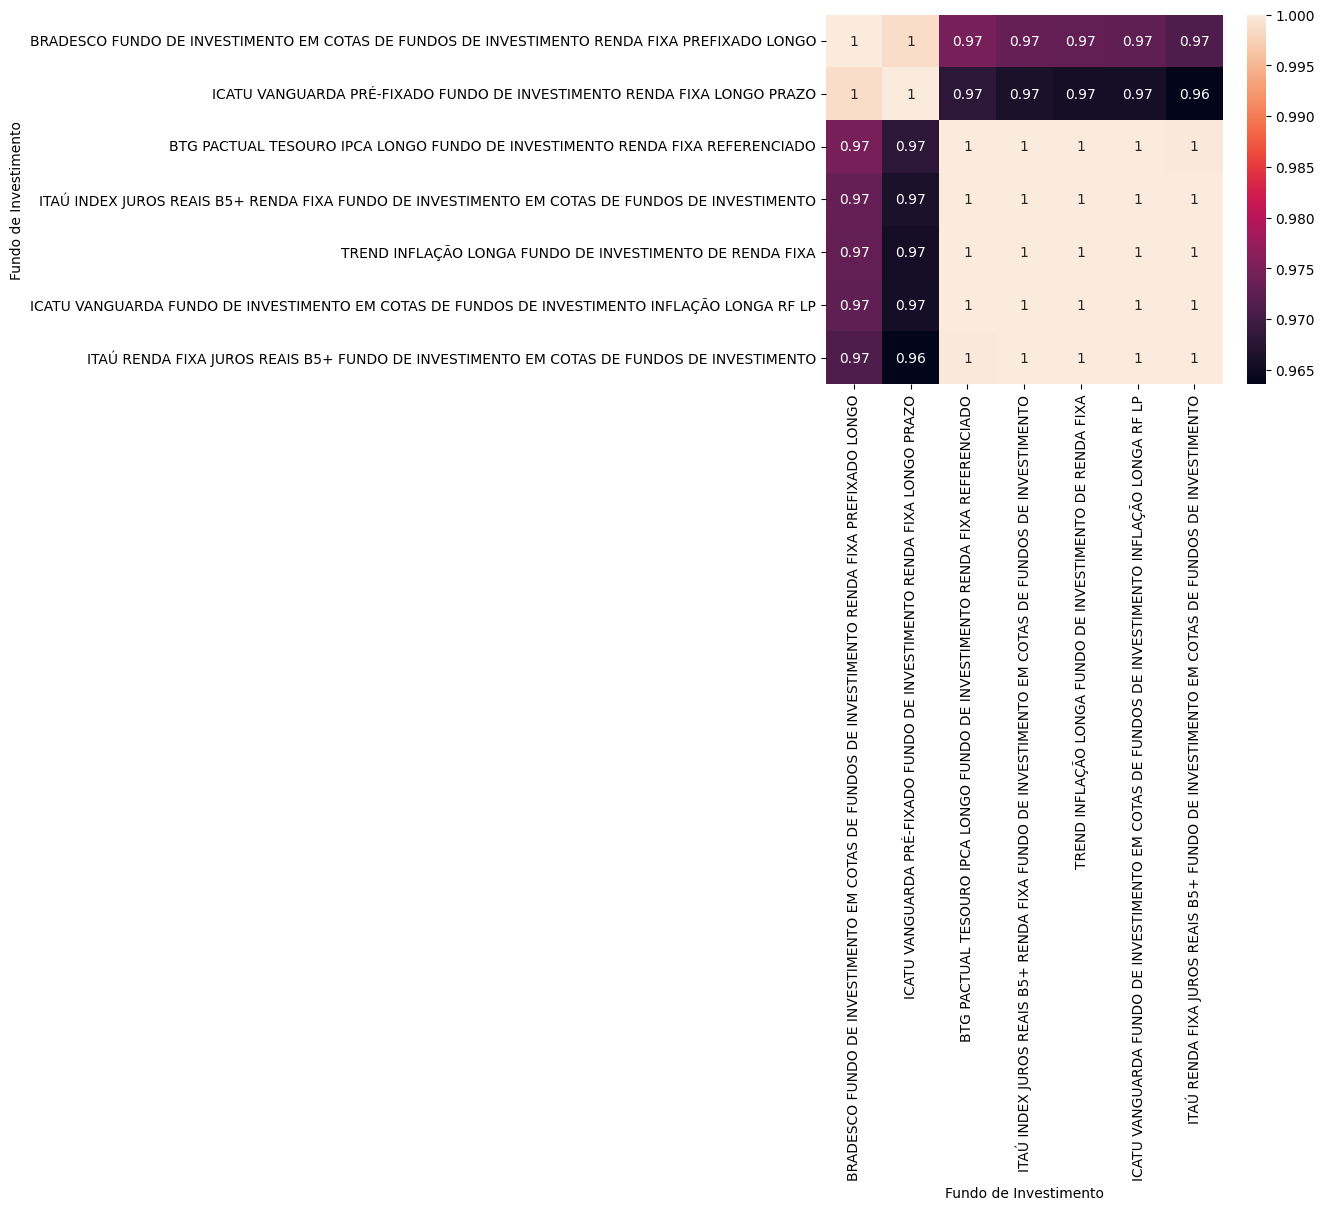

In [48]:
sns.heatmap(cotas.iloc[:, :7].corr(), annot=True);